In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget -q 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-39pvj8nw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-39pvj8nw
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [6]:
!wget -q 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_01ec64.pth'

In [7]:
!pip install ultralytics

In [8]:
!pip install pydantic==1.10.13

In [9]:
!mkdir /content/data
!cp /content/drive/MyDrive/DentalImages/ToothSegDataset/DentalPanoramicXrays.zip /content/data
!cp /content/drive/MyDrive/DentalImages/ToothSegDataset/Masks.zip /content/data

mkdir: cannot create directory ‘/content/data’: File exists


(3, 1024, 1024)
(1300, 3100, 3)


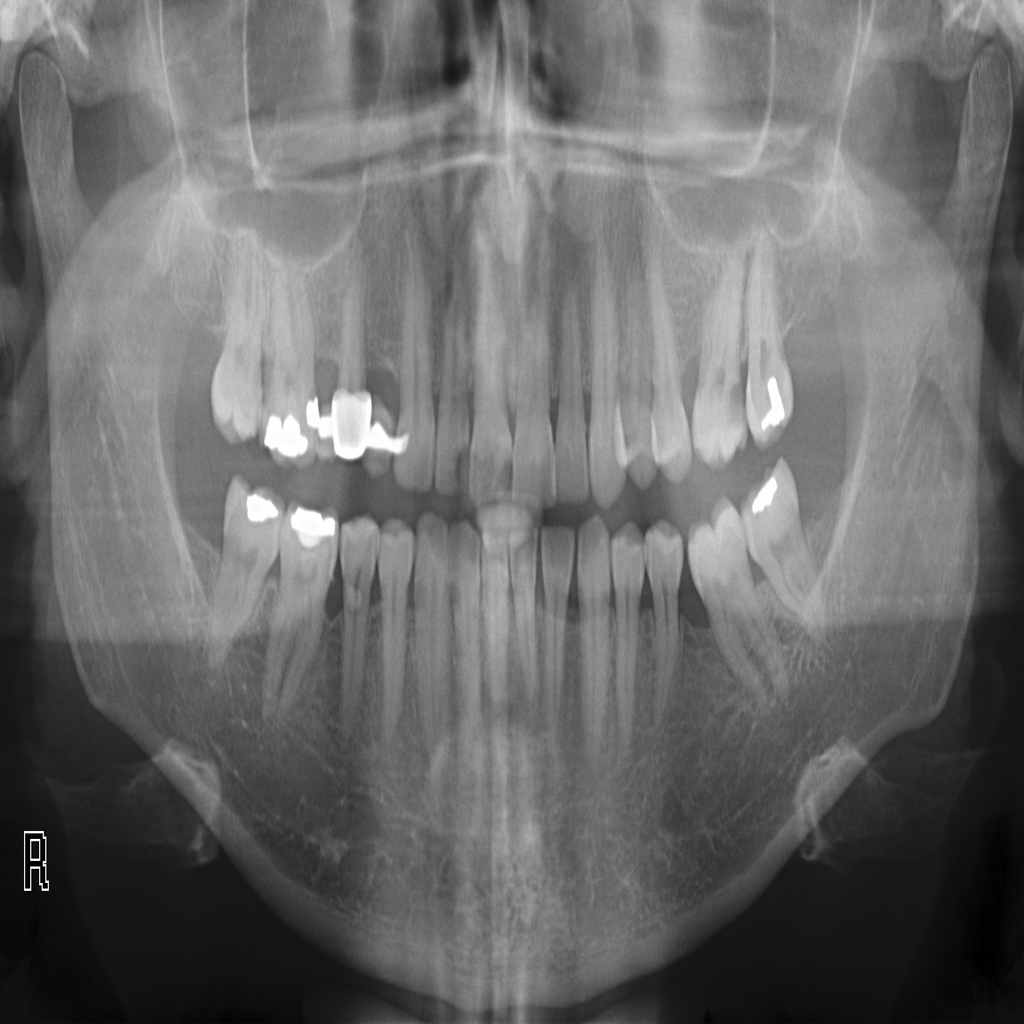

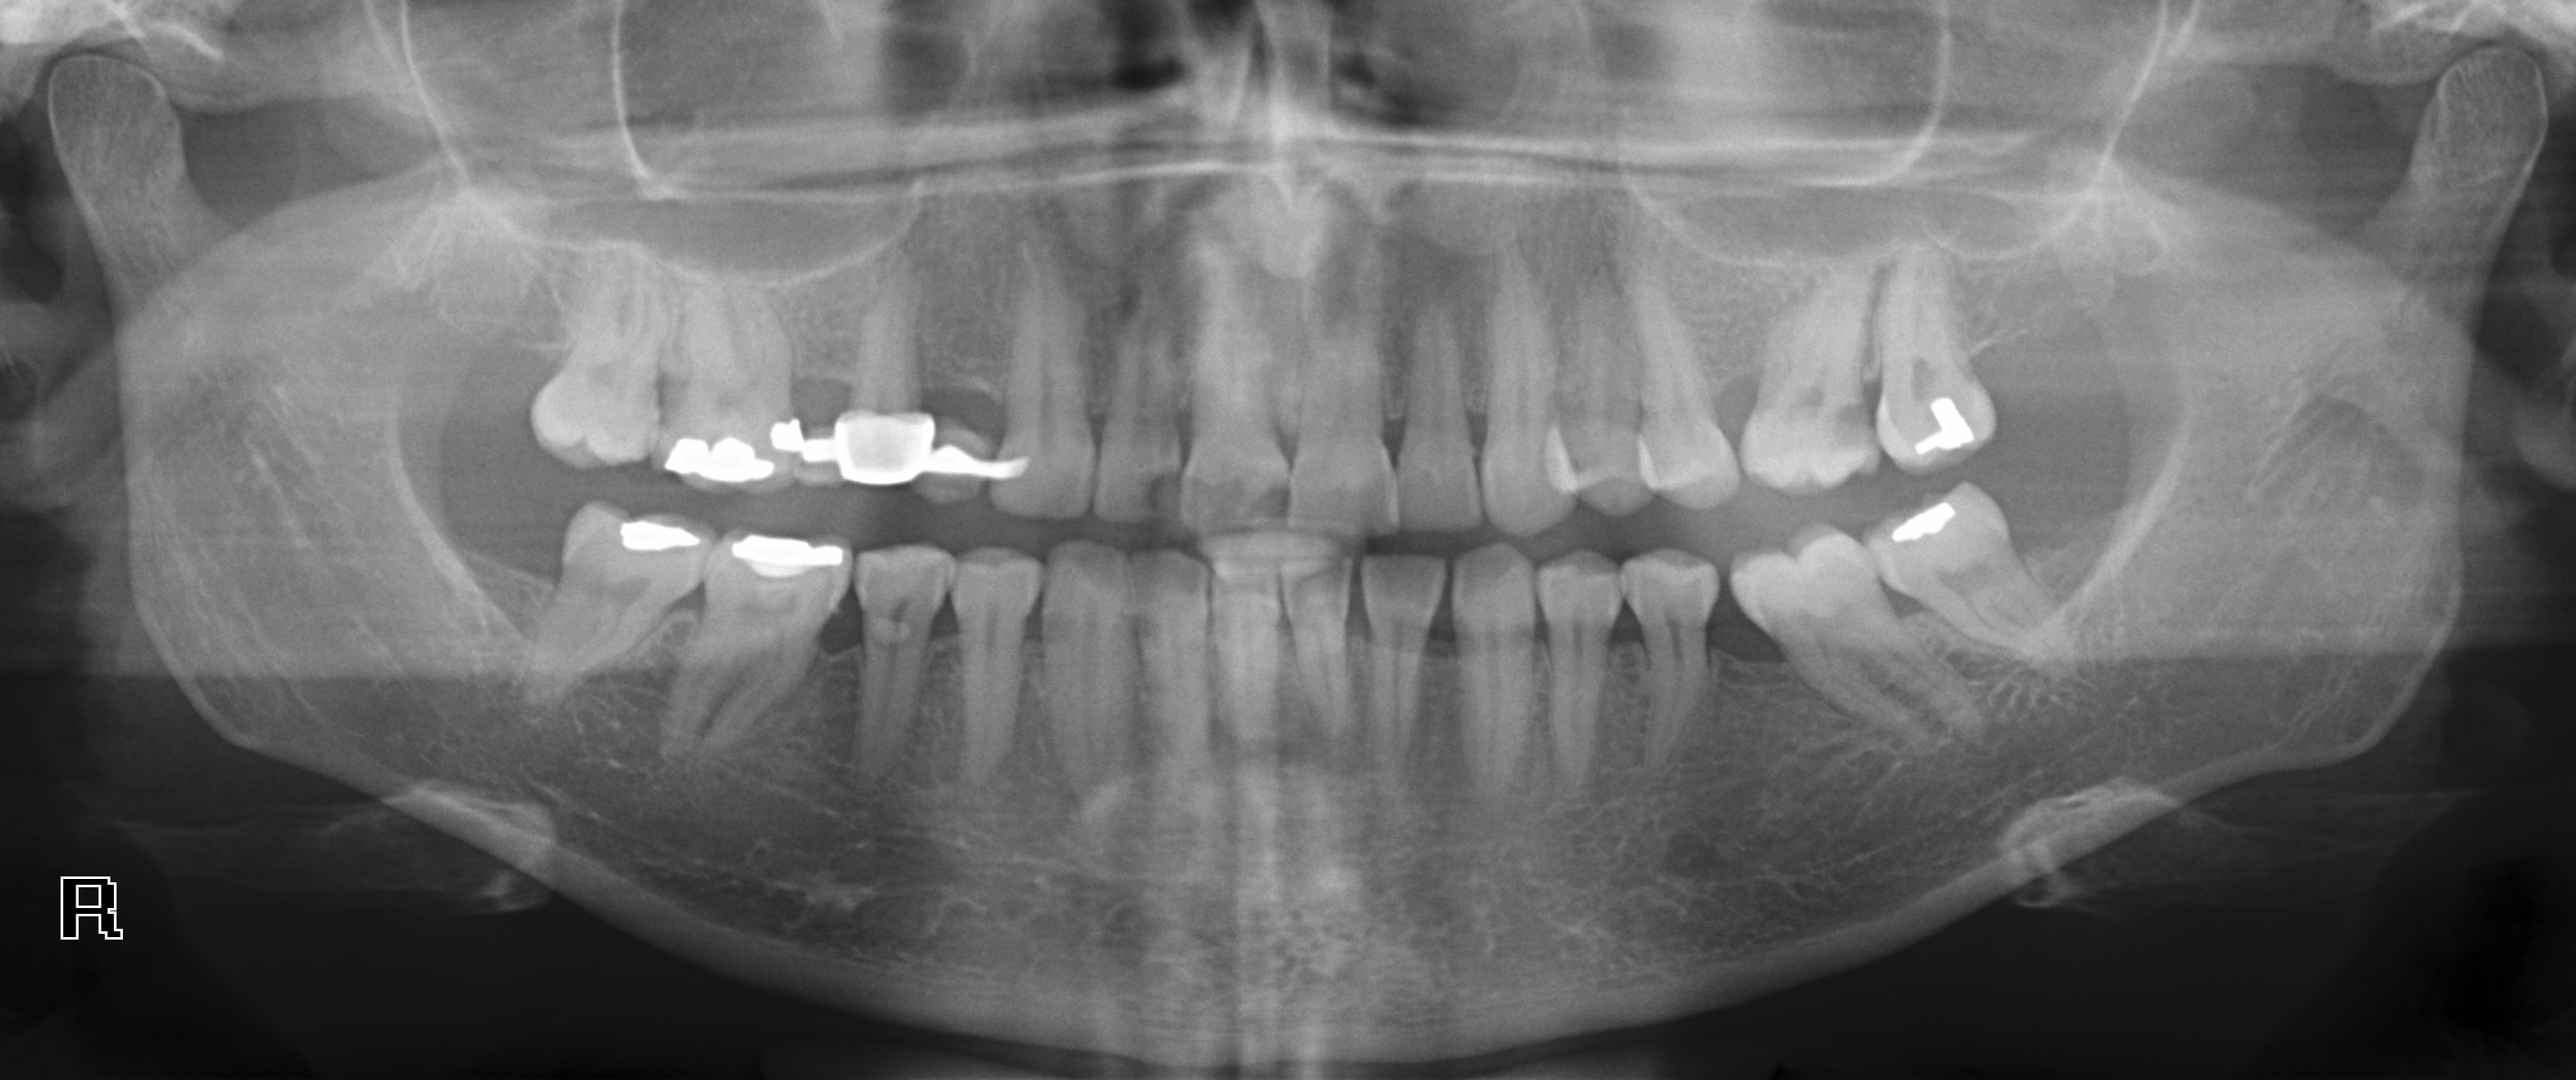

In [10]:
import cv2
import numpy as np
import os
import torch
from google.colab.patches import cv2_imshow
from PIL import Image
from zipfile import ZipFile
from natsort import natsorted

def convert_to_three_channel(img):
  if len(img.shape) <= 2:
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

  img = np.moveaxis(img, -1, 0)
  return img

def convert_to_three_channel_yolo(img):
  if len(img.shape) <= 2:
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  return img

def convert_to_one_channel(img):
  if len(img.shape) > 2:
    img = img[:,:,0]
  return img

def extract_image_paths(path, zip_name, folder_name, save_path):
  full_path = os.path.join(path, zip_name)
  ZipFile(full_path).extractall(save_path)
  unzipped_path = os.path.join(path, folder_name)
  dirs=natsorted(os.listdir(unzipped_path))
  return dirs

def load_images(resize_shape, path, zip_name, folder_name, save_path, convert_function):

    dirs = extract_image_paths(path, zip_name, folder_name, save_path)

    images = []

    for i in range(len(dirs)):
        img=Image.open(os.path.join(path, folder_name, dirs[i]))
        img=img.resize((resize_shape), Image.LANCZOS )

        img = convert_function(np.asarray(img))
        images.append(img)

    images = np.array(images)
    return images

def load_yolo_images(path, resize_shape):
  image_names = natsorted(os.listdir(path))
  images=[]

  for image_name in image_names:
    img = Image.open(os.path.join(path, image_name))
    if len(images)>0:
      img = img.resize(resize_shape, Image.LANCZOS)

    img = convert_to_three_channel_yolo(np.asarray(img))

    img = np.array(img)
    images.append(img)

  images = np.array(images)
  return images



PATH = "/content/data/"
X = load_images((1024, 1024), PATH, "DentalPanoramicXrays.zip",'Images/', "/content/data", convert_to_three_channel)
Y = load_images((1024, 1024), PATH, "Masks.zip", "Masks/", "/content/data/Masks", convert_to_one_channel)
X_yolo = load_yolo_images("/content/data/Images",(3100,1300))

x_train = X[:88]
x_val = X[88:]
y_train = Y[:88]
y_val = Y[88:]
x_train_yolo = X_yolo[:88]
x_val_yolo = X_yolo[88:]

print(x_train[3].shape)
print(x_train_yolo[3].shape)
cv2_imshow(x_train[3,0])
cv2_imshow(x_train_yolo[3])






In [11]:
def get_fixed_coordinates(box, image):

  x_center = box[0].numpy()
  y_center = box[1].numpy()
  width = box[2].numpy()
  height = box[3].numpy()
  x_center *= image.shape[0]
  y_center *= image.shape[1]
  width *= image.shape[0]
  height *= image.shape[1]

  x1 = int(x_center - width / 2)
  y1 = int(y_center - height / 2)
  x2 = int(x_center + width / 2)
  y2 = int(y_center + height / 2)

  return x1, y1, x2, y2


  0%|          | 0/100 [00:00<?, ?it/s]


0: 288x640 33 tooths, 8.1ms
Speed: 25.3ms preprocess, 8.1ms inference, 8.9ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


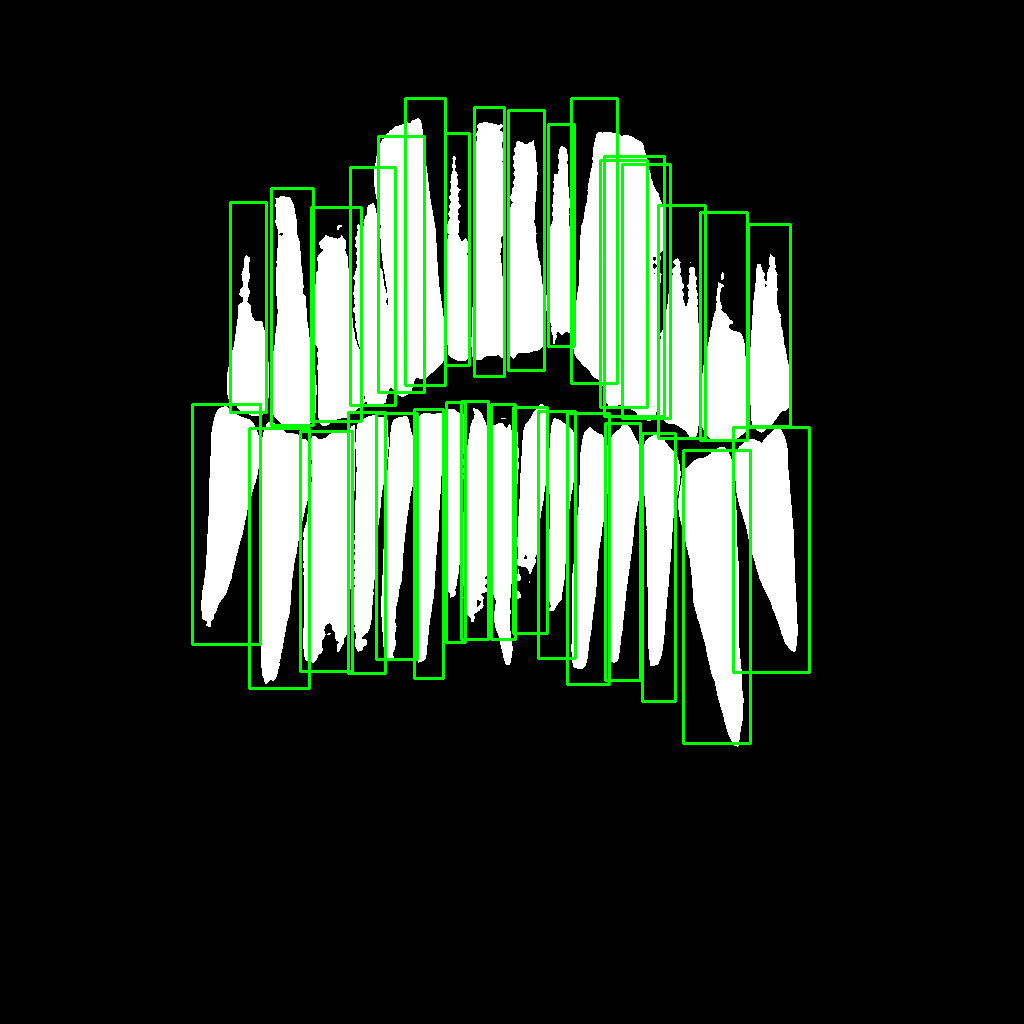

Max, min in prediction tensor(3., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1024, 1024])) that is different to the input size (torch.Size([1024, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:08<13:53,  8.41s/it]

Loss: 0.08365319669246674

0: 288x640 33 tooths, 7.7ms
Speed: 2.0ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


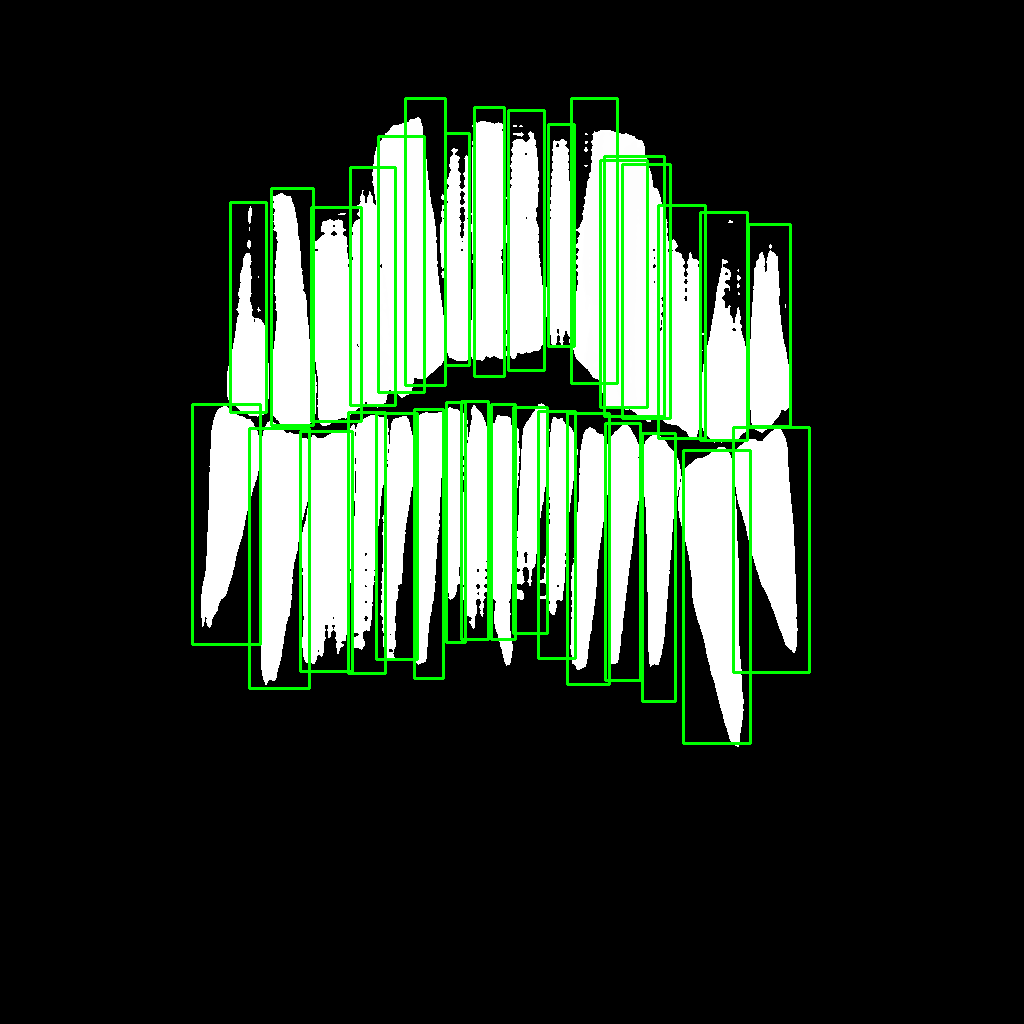

Max, min in prediction tensor(3., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


  2%|▏         | 2/100 [00:16<13:33,  8.30s/it]

Loss: 0.10599657893180847

0: 288x640 33 tooths, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


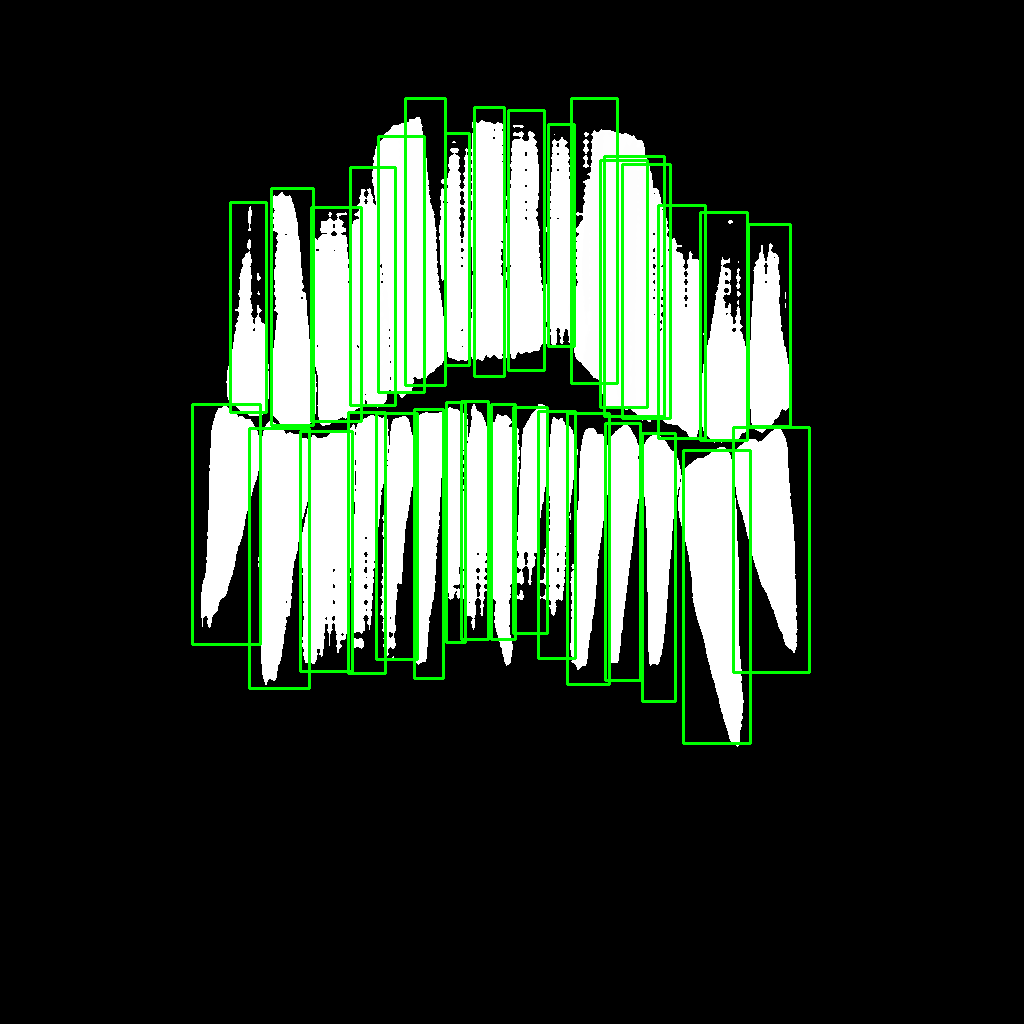

Max, min in prediction tensor(3., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


  3%|▎         | 3/100 [00:26<14:33,  9.00s/it]

Loss: 0.11261938512325287

0: 288x640 33 tooths, 7.7ms
Speed: 2.0ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


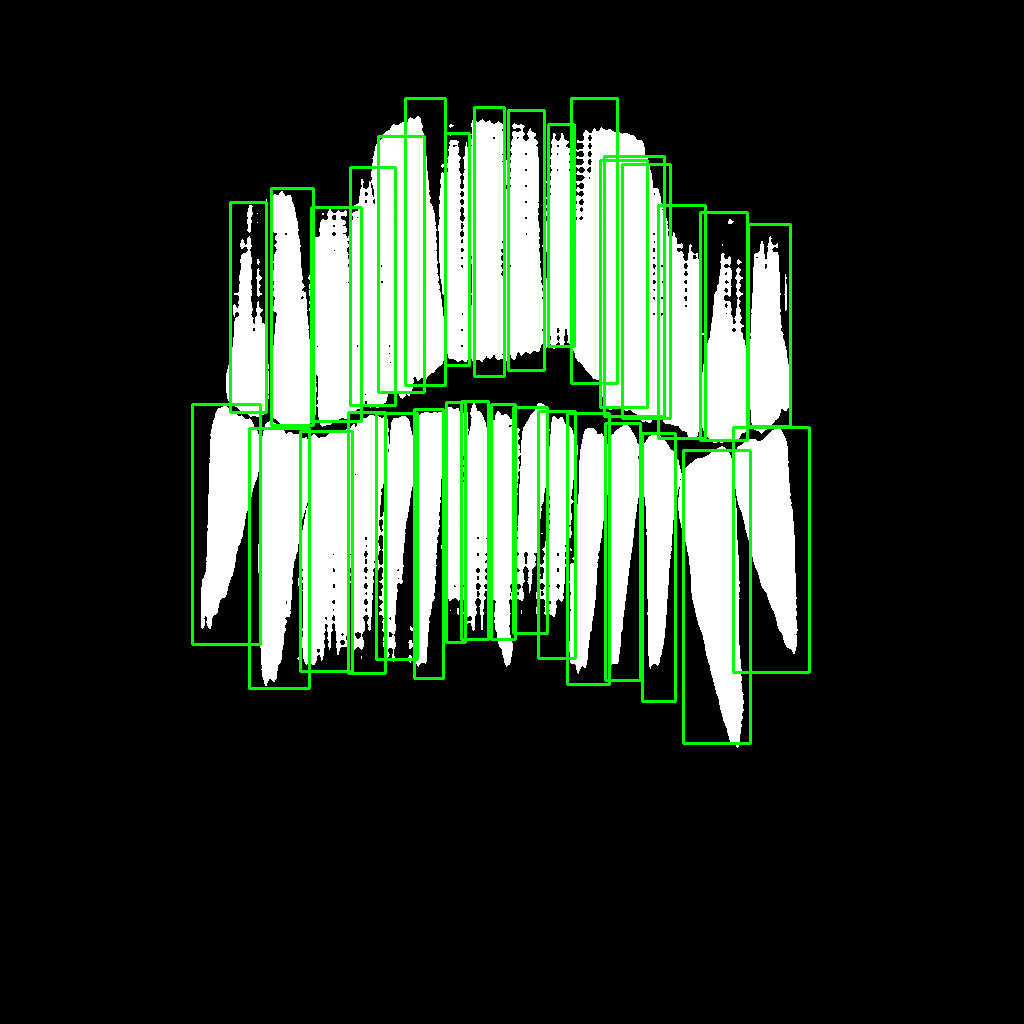

Max, min in prediction tensor(4., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


  4%|▍         | 4/100 [00:35<14:24,  9.01s/it]

Loss: 0.12579131126403809

0: 288x640 33 tooths, 12.0ms
Speed: 2.3ms preprocess, 12.0ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


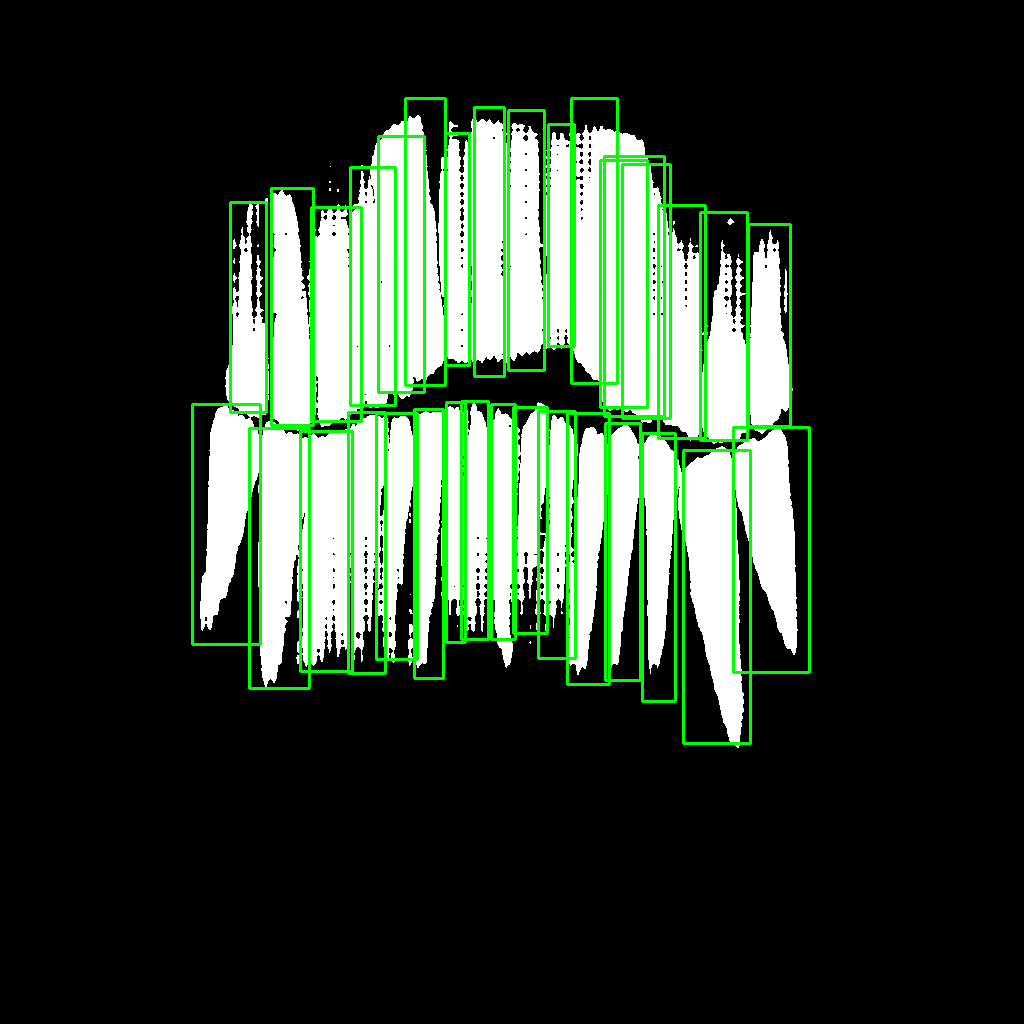

Max, min in prediction tensor(4., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


  5%|▌         | 5/100 [00:43<13:53,  8.77s/it]

Loss: 0.13693854212760925

0: 288x640 33 tooths, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


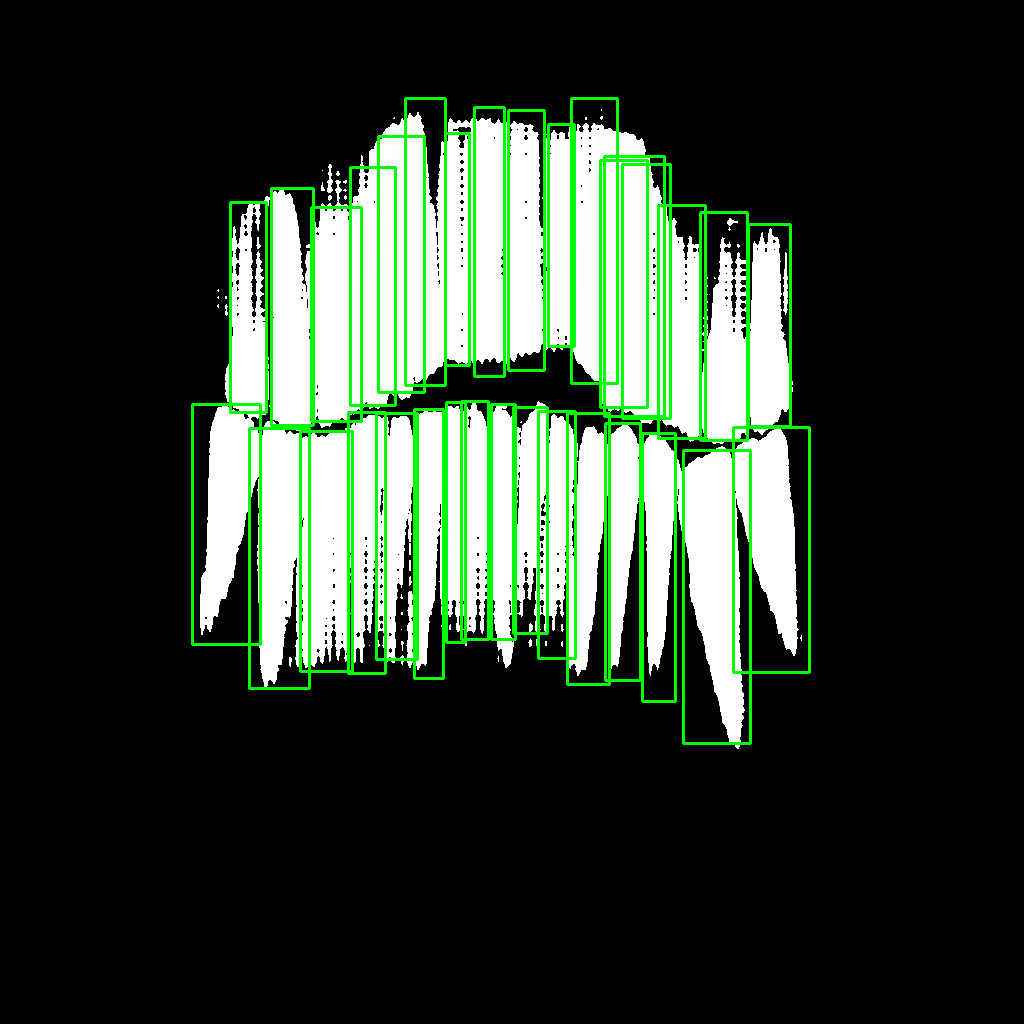

Max, min in prediction tensor(4., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


  6%|▌         | 6/100 [00:54<14:32,  9.28s/it]

Loss: 0.16514506936073303

0: 288x640 33 tooths, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


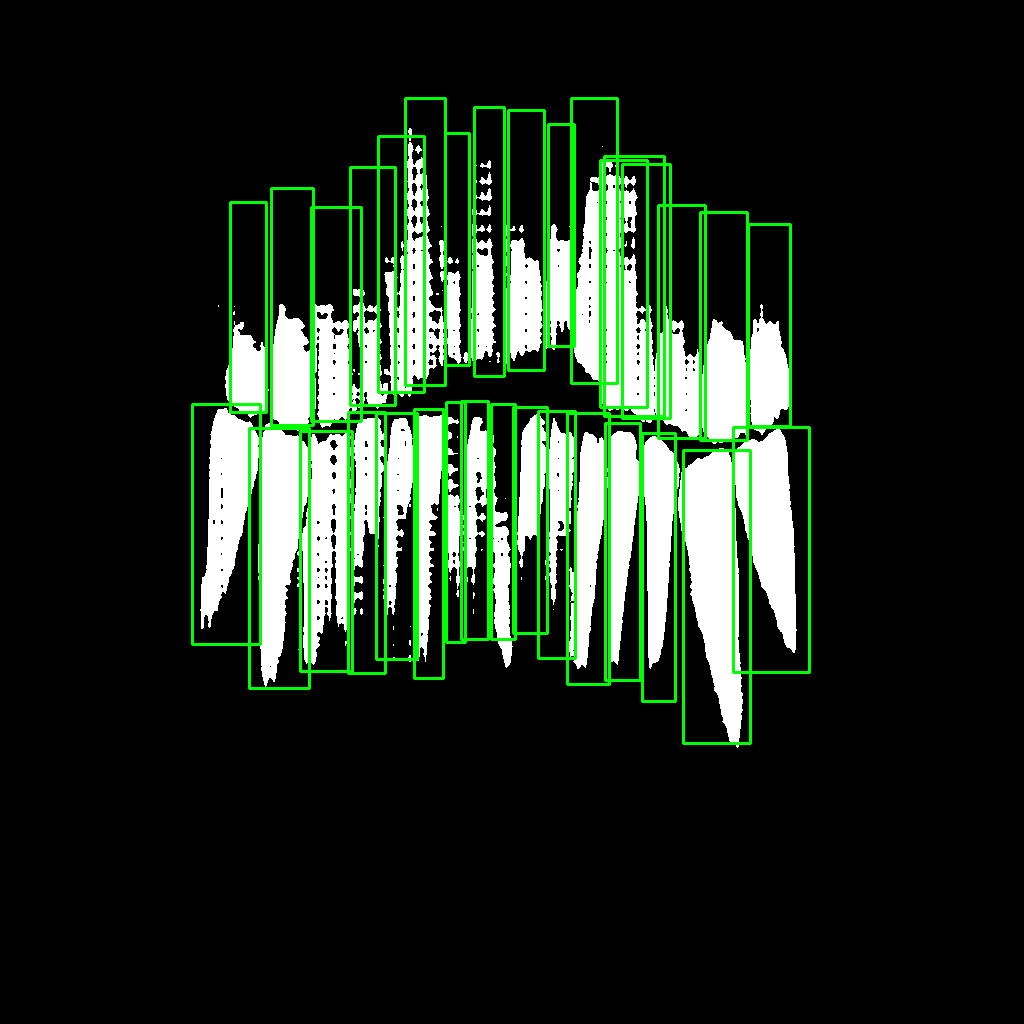

Max, min in prediction tensor(4., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


  7%|▋         | 7/100 [01:04<14:50,  9.58s/it]

Loss: 0.09633159637451172

0: 288x640 33 tooths, 7.6ms
Speed: 2.0ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


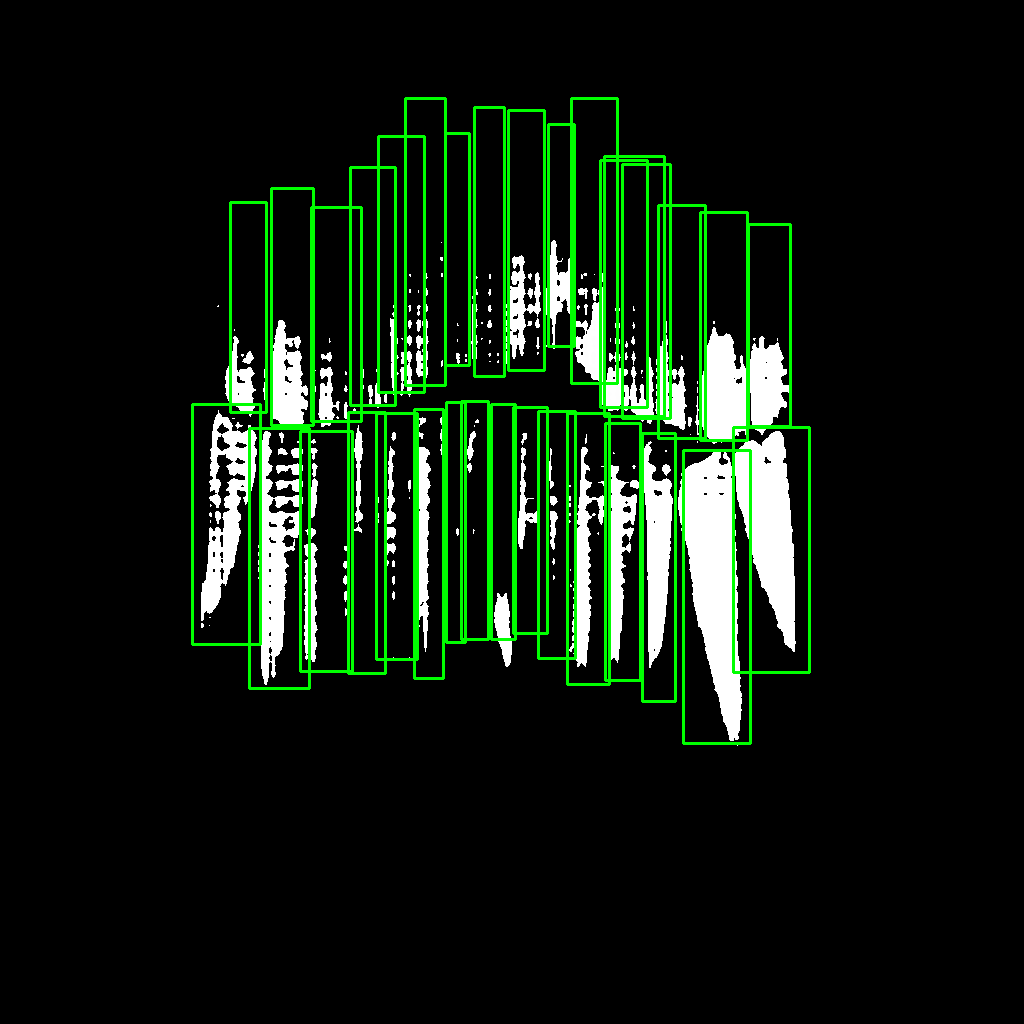

Max, min in prediction tensor(5., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


  8%|▊         | 8/100 [01:12<14:04,  9.18s/it]

Loss: 0.13494685292243958

0: 288x640 33 tooths, 10.6ms
Speed: 2.6ms preprocess, 10.6ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


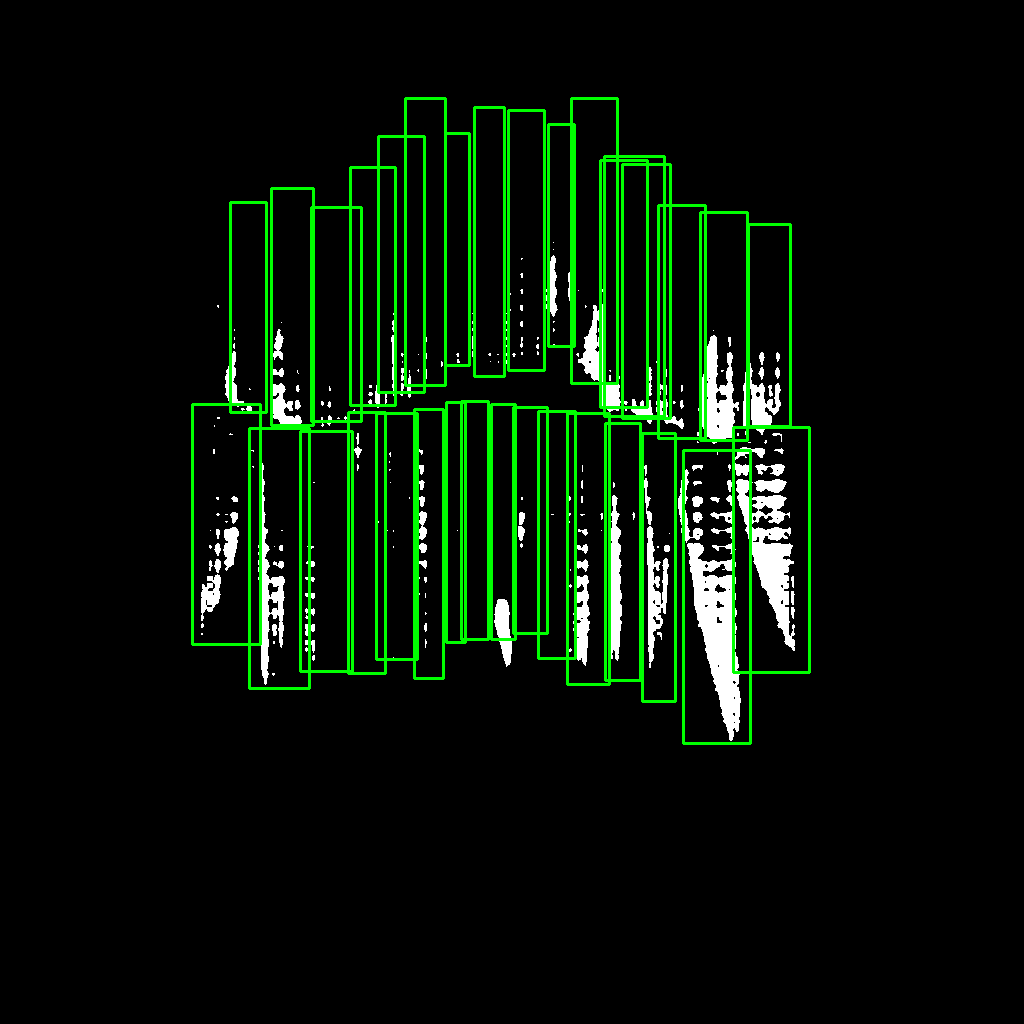

Max, min in prediction tensor(5., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


  9%|▉         | 9/100 [01:21<13:38,  8.99s/it]

Loss: 0.16678676009178162

0: 288x640 33 tooths, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


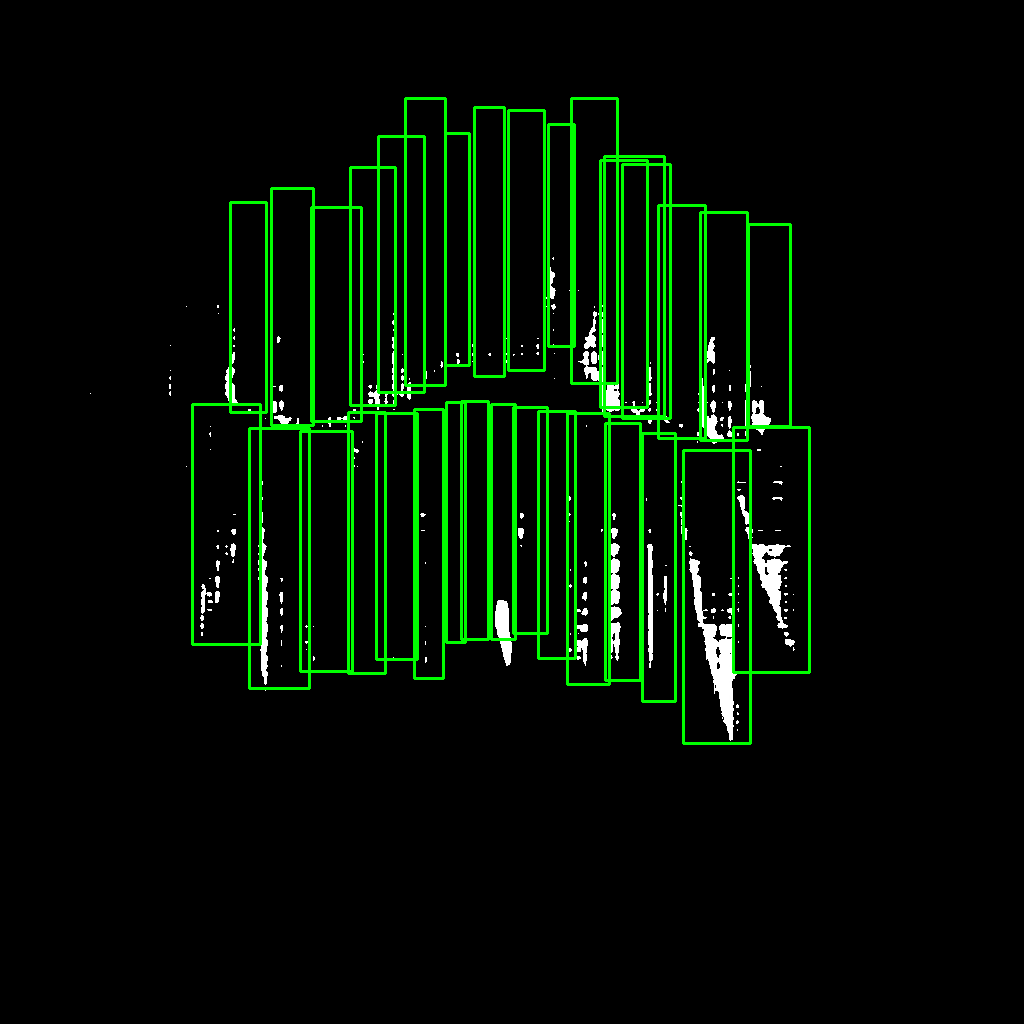

Max, min in prediction tensor(5., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 10%|█         | 10/100 [01:31<13:55,  9.29s/it]

Loss: 0.1825157105922699

0: 288x640 33 tooths, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


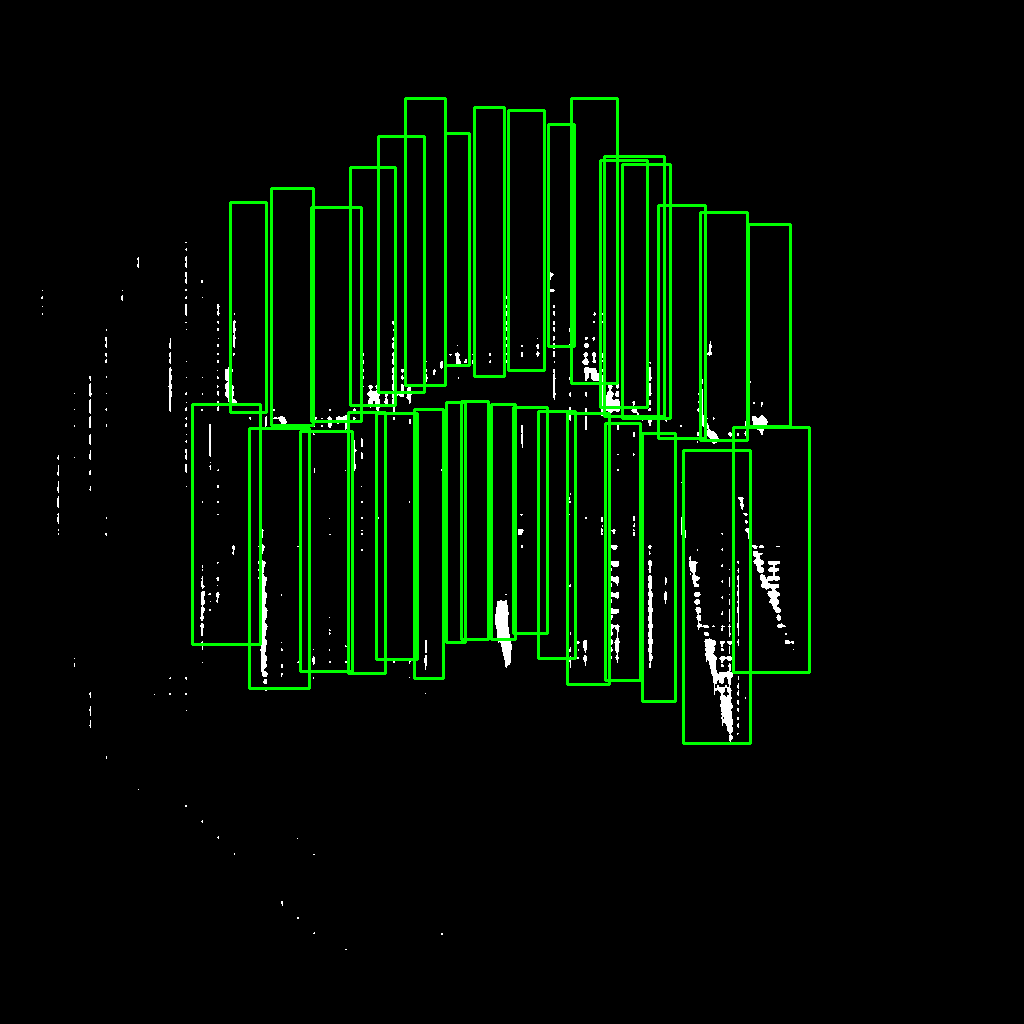

Max, min in prediction tensor(10., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 11%|█         | 11/100 [01:39<13:31,  9.12s/it]

Loss: 0.19399793446063995

0: 288x640 33 tooths, 12.2ms
Speed: 2.5ms preprocess, 12.2ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


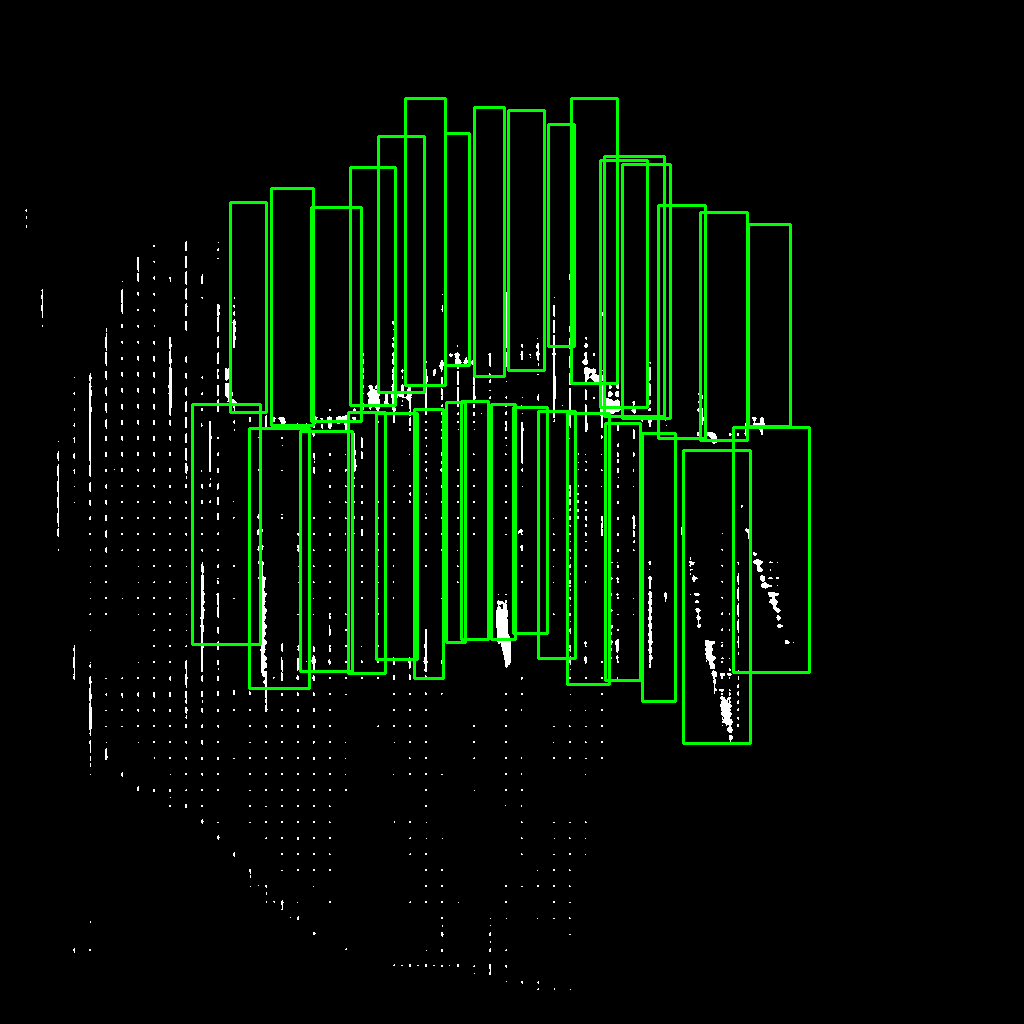

Max, min in prediction tensor(15., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 12%|█▏        | 12/100 [01:48<13:01,  8.88s/it]

Loss: 0.25765734910964966

0: 288x640 33 tooths, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


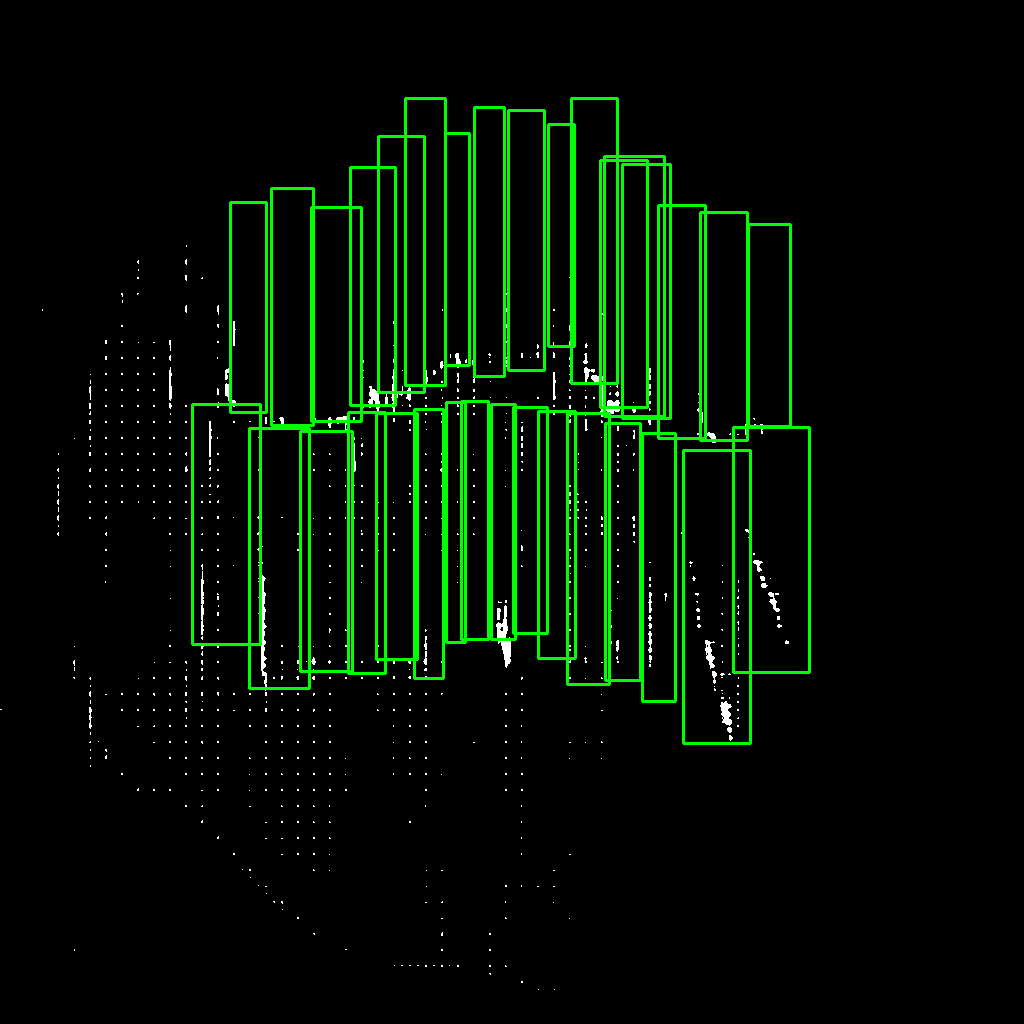

Max, min in prediction tensor(15., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 13%|█▎        | 13/100 [01:58<13:21,  9.21s/it]

Loss: 0.220102921128273

0: 288x640 33 tooths, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


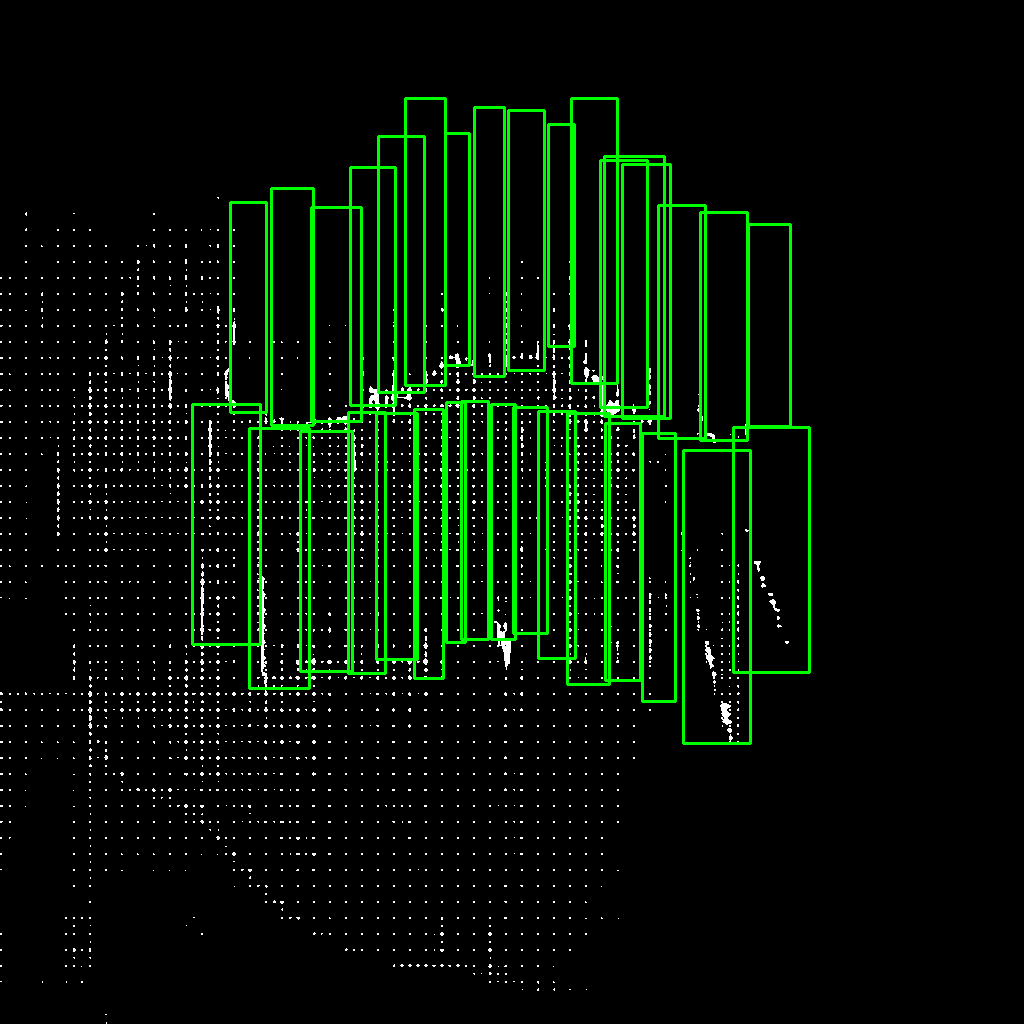

Max, min in prediction tensor(24., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 14%|█▍        | 14/100 [02:07<13:07,  9.16s/it]

Loss: 0.7109988927841187

0: 288x640 33 tooths, 7.6ms
Speed: 2.1ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


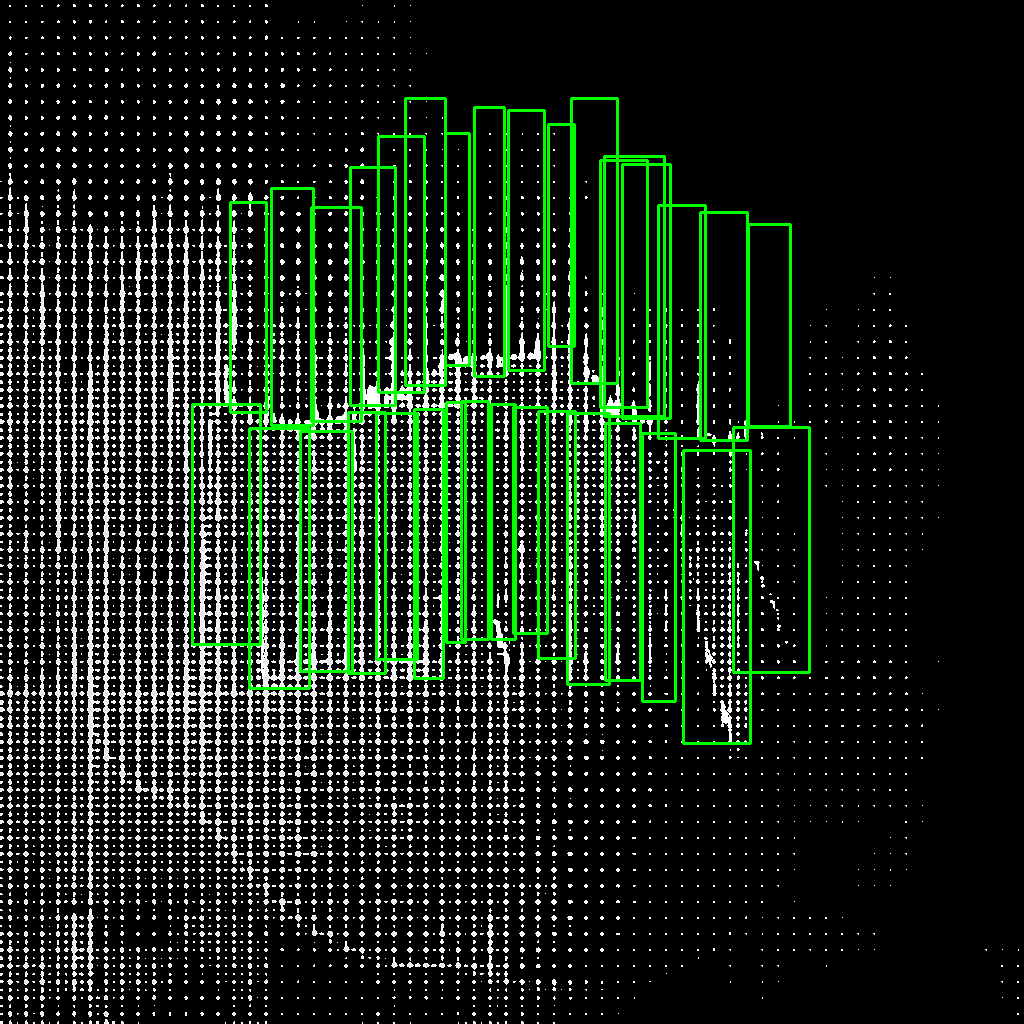

Max, min in prediction tensor(33., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 15%|█▌        | 15/100 [02:15<12:39,  8.94s/it]

Loss: 15.202167510986328

0: 288x640 33 tooths, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


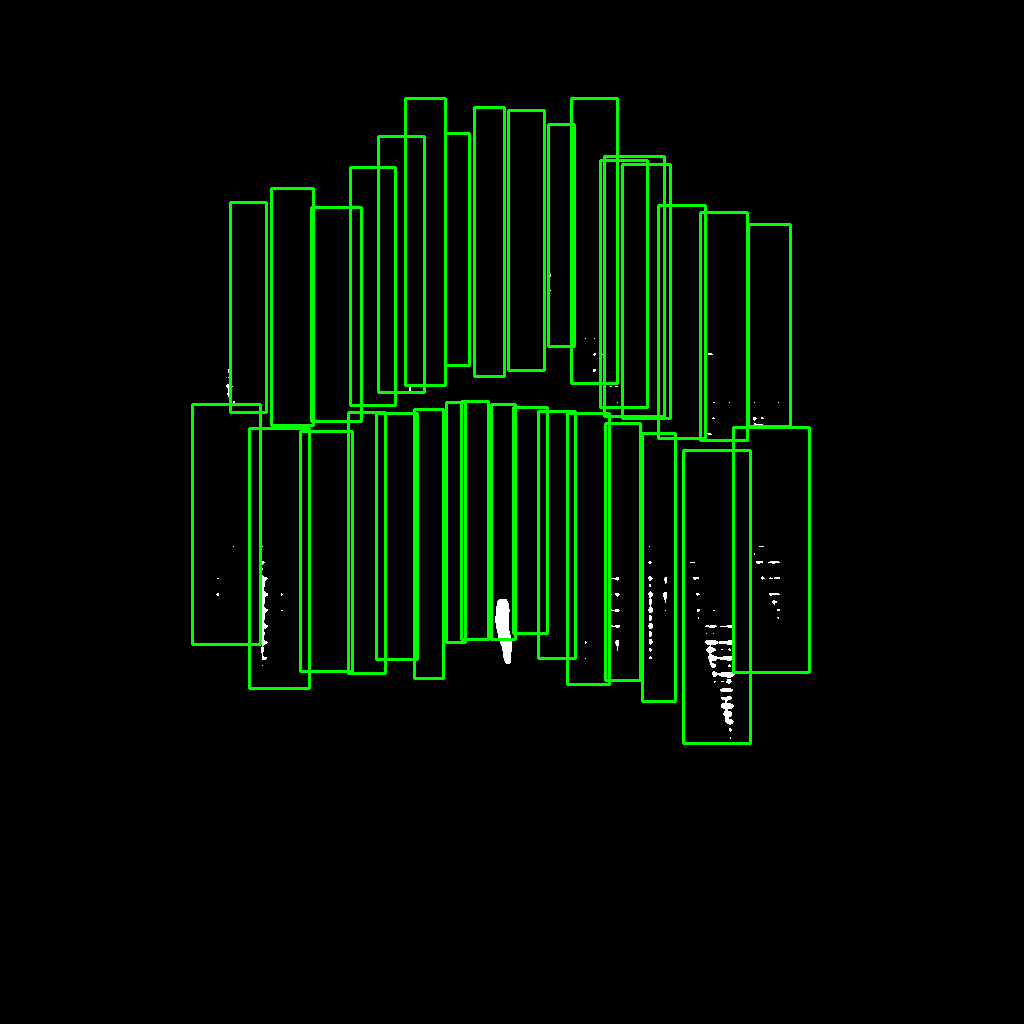

Max, min in prediction tensor(2., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 16%|█▌        | 16/100 [02:25<12:51,  9.19s/it]

Loss: 0.19151118397712708

0: 288x640 33 tooths, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


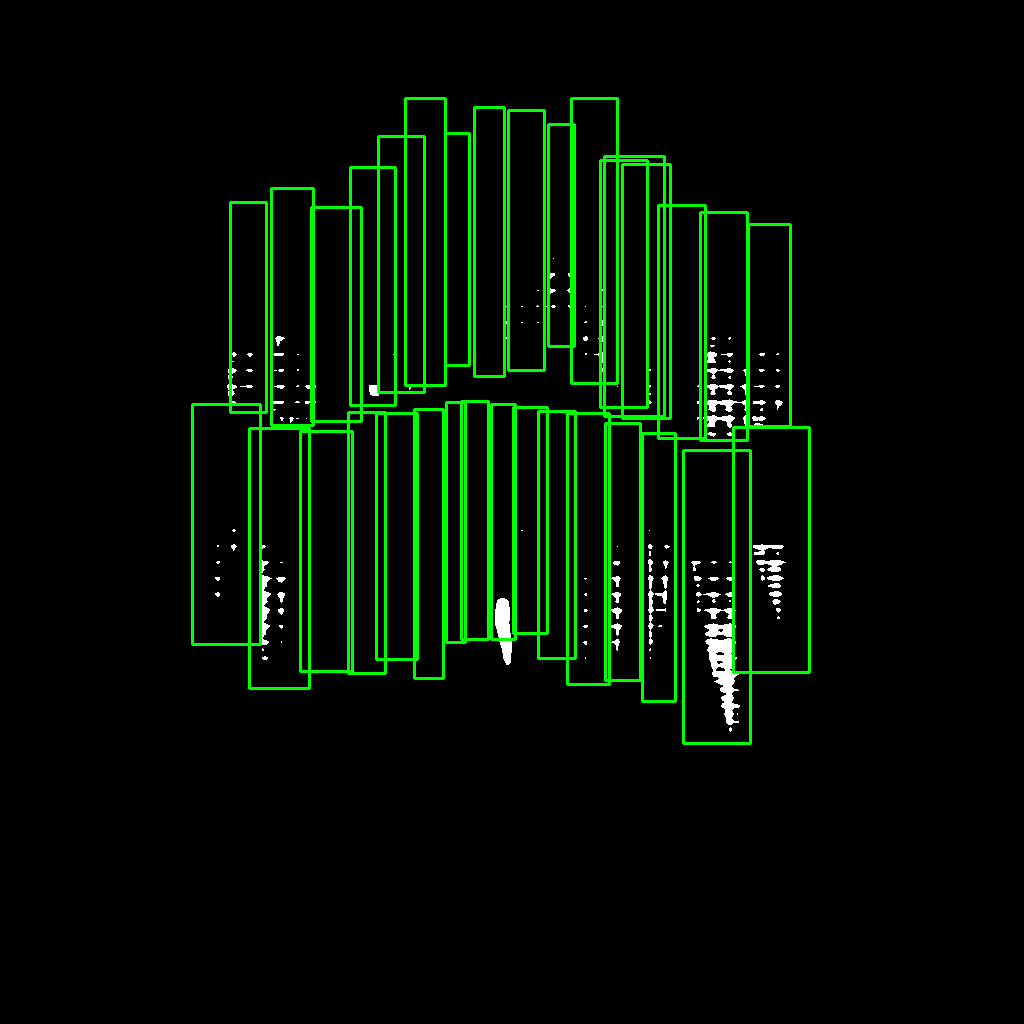

Max, min in prediction tensor(3., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 17%|█▋        | 17/100 [02:35<12:58,  9.38s/it]

Loss: 0.1902579665184021

0: 288x640 33 tooths, 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


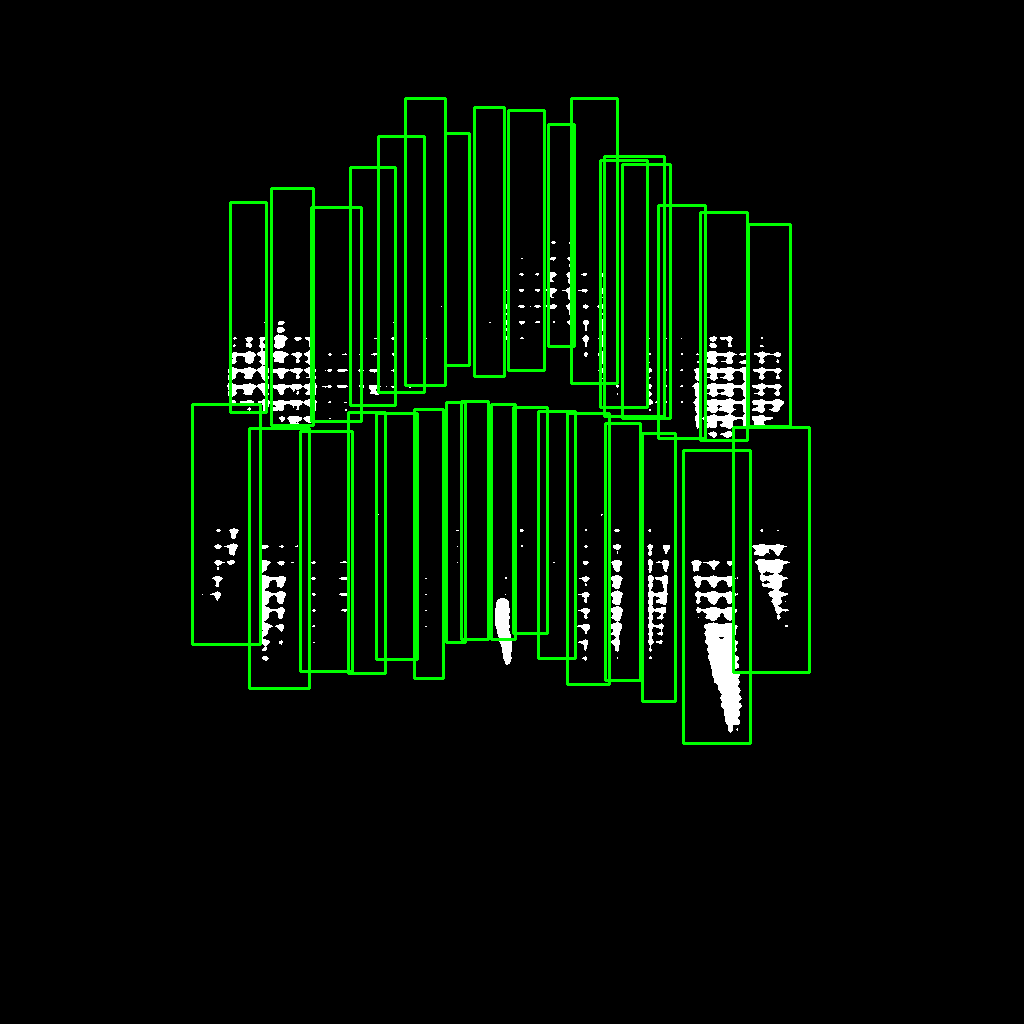

Max, min in prediction tensor(4., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 18%|█▊        | 18/100 [02:43<12:24,  9.08s/it]

Loss: 0.1867561936378479

0: 288x640 33 tooths, 17.6ms
Speed: 2.8ms preprocess, 17.6ms inference, 9.0ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


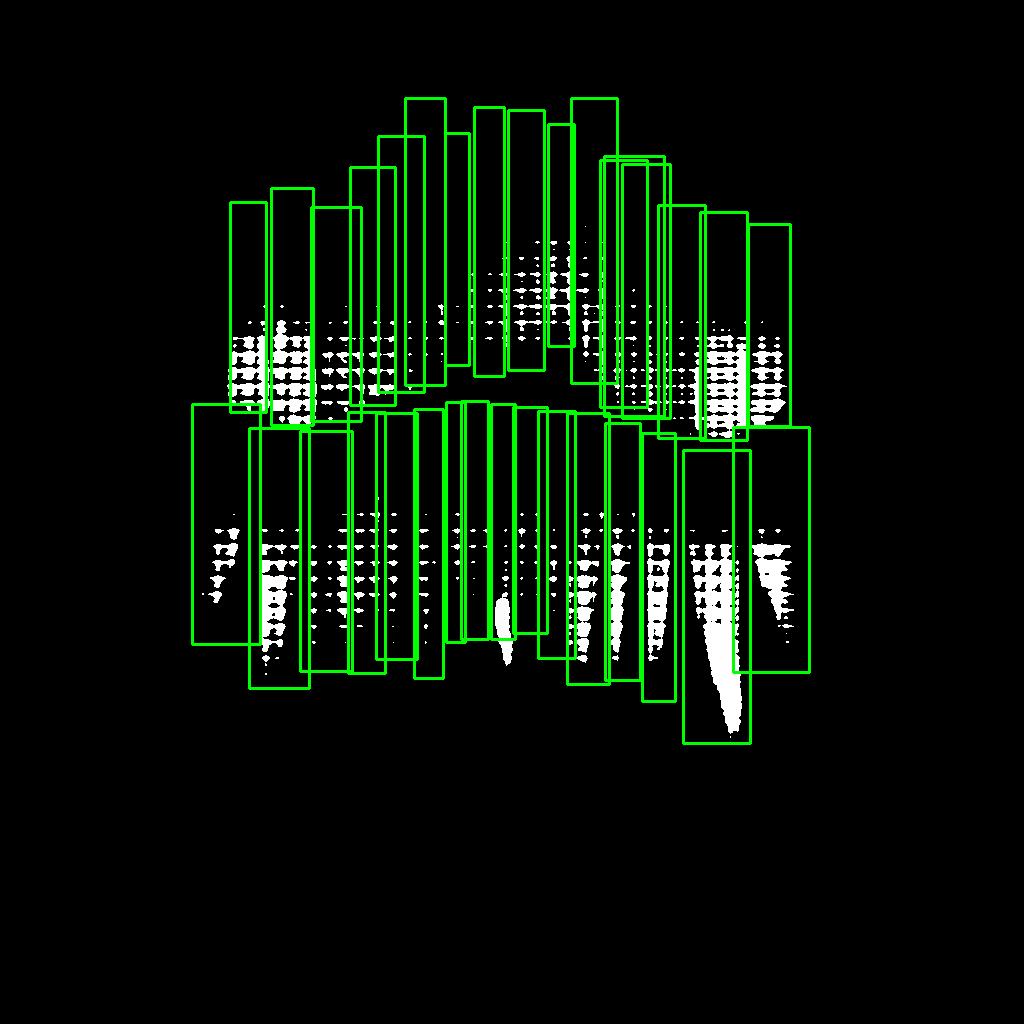

Max, min in prediction tensor(6., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 19%|█▉        | 19/100 [02:52<12:13,  9.06s/it]

Loss: 0.1924254596233368

0: 288x640 33 tooths, 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


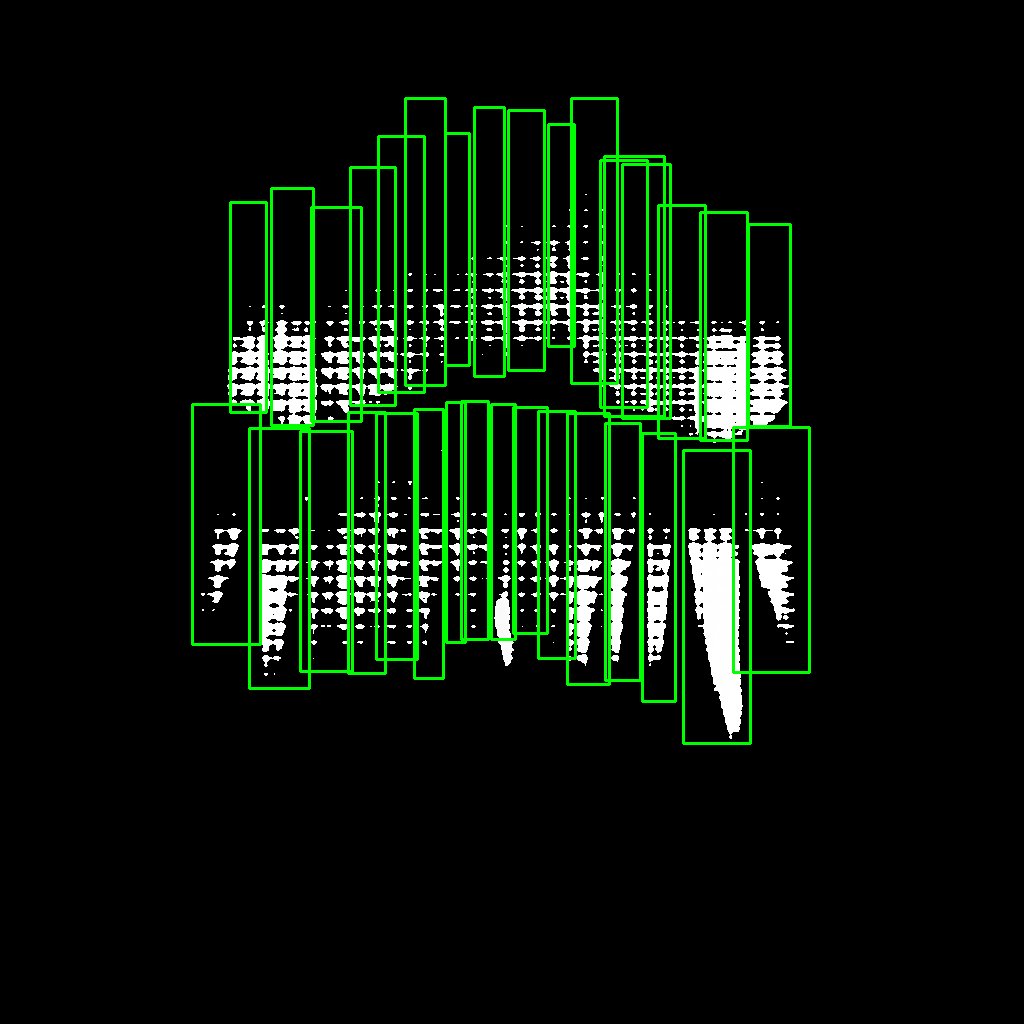

Max, min in prediction tensor(8., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 20%|██        | 20/100 [03:02<12:28,  9.36s/it]

Loss: 0.23549354076385498

0: 288x640 33 tooths, 7.6ms
Speed: 2.1ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


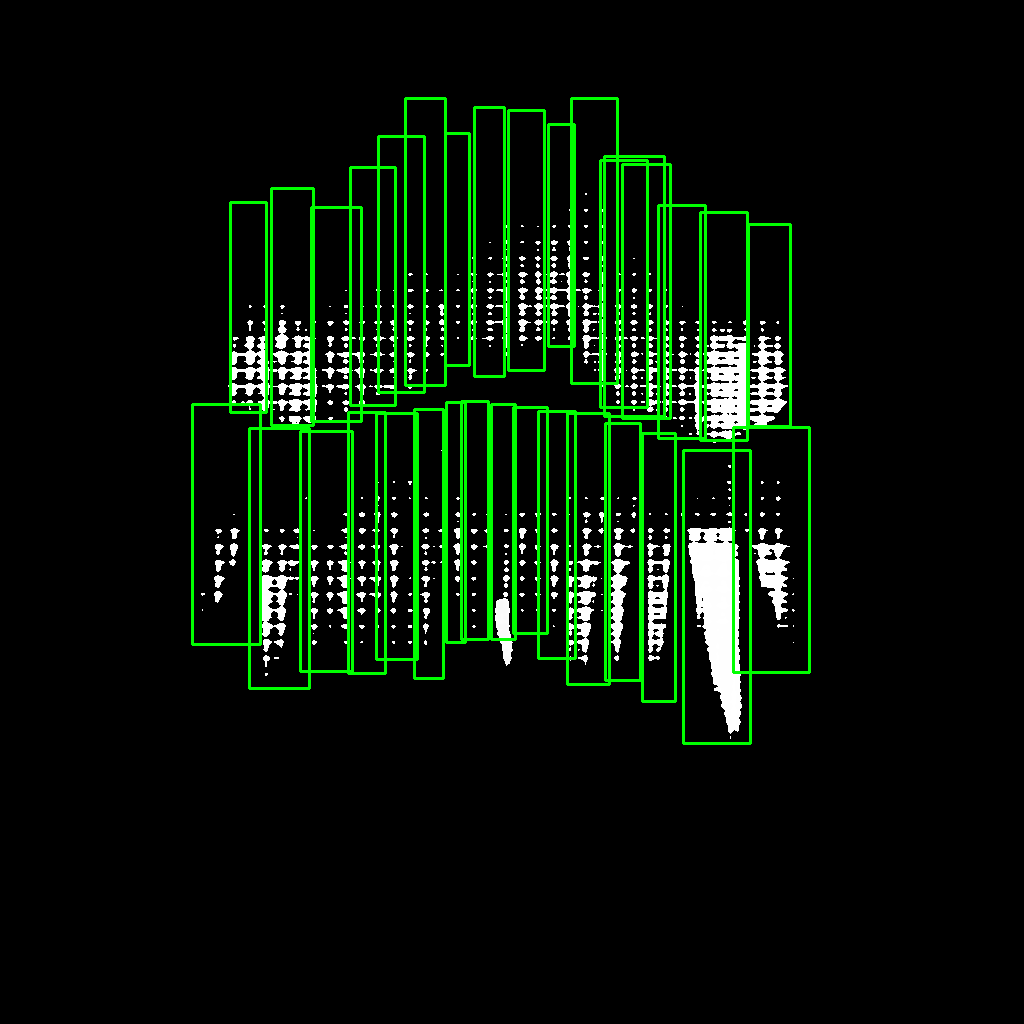

Max, min in prediction tensor(8., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 21%|██        | 21/100 [03:11<12:02,  9.15s/it]

Loss: 0.22178331017494202

0: 288x640 33 tooths, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


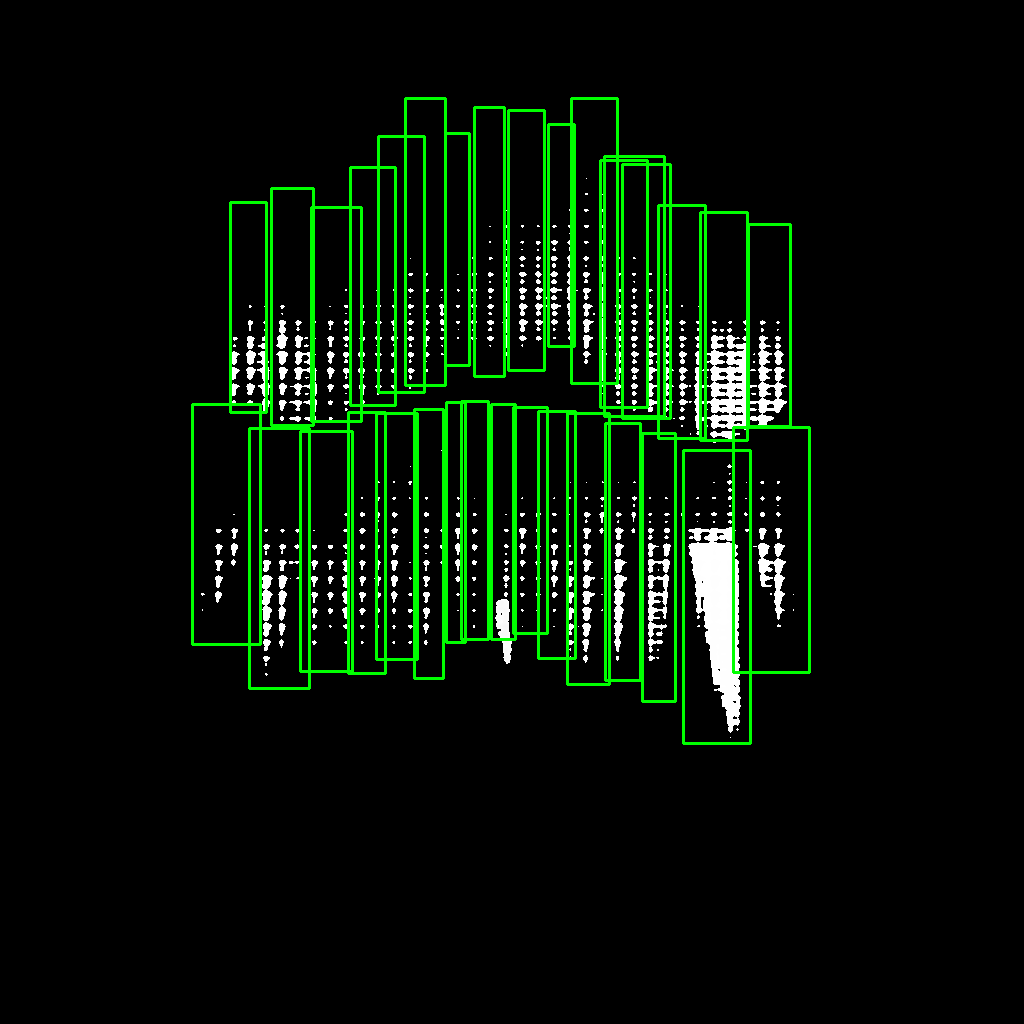

Max, min in prediction tensor(9., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 22%|██▏       | 22/100 [03:19<11:37,  8.94s/it]

Loss: 0.22156447172164917

0: 288x640 33 tooths, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


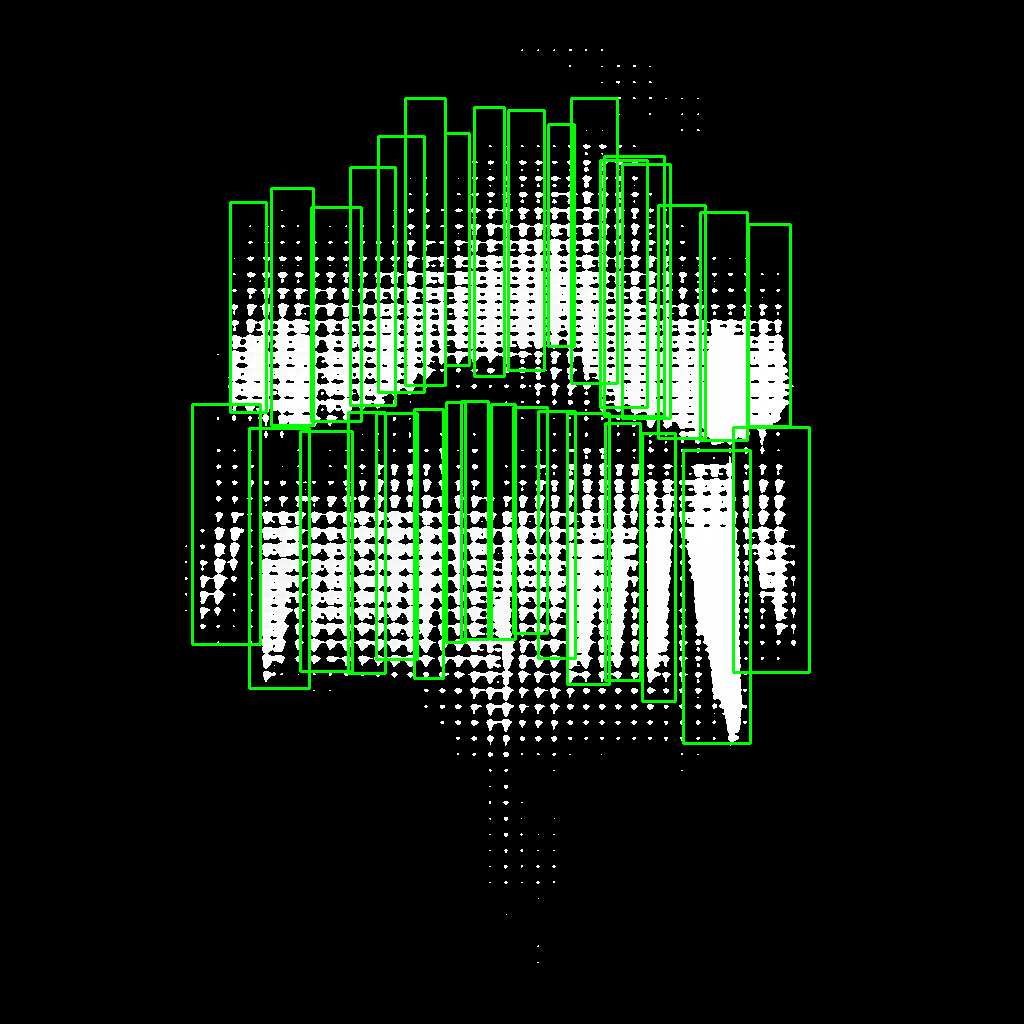

Max, min in prediction tensor(16., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 23%|██▎       | 23/100 [03:29<11:52,  9.25s/it]

Loss: 2.37328839302063

0: 288x640 33 tooths, 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


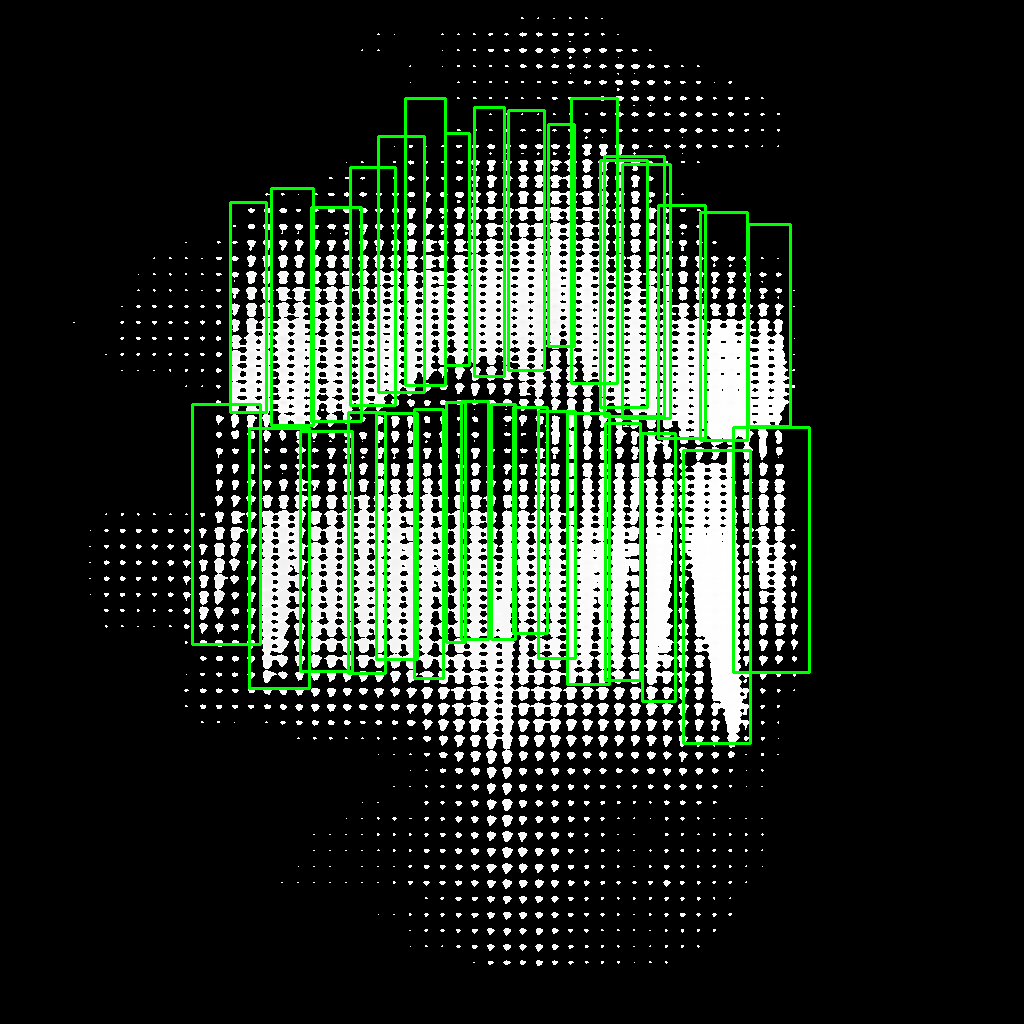

Max, min in prediction tensor(18., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 24%|██▍       | 24/100 [03:38<11:38,  9.19s/it]

Loss: 5.875776290893555

0: 288x640 33 tooths, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


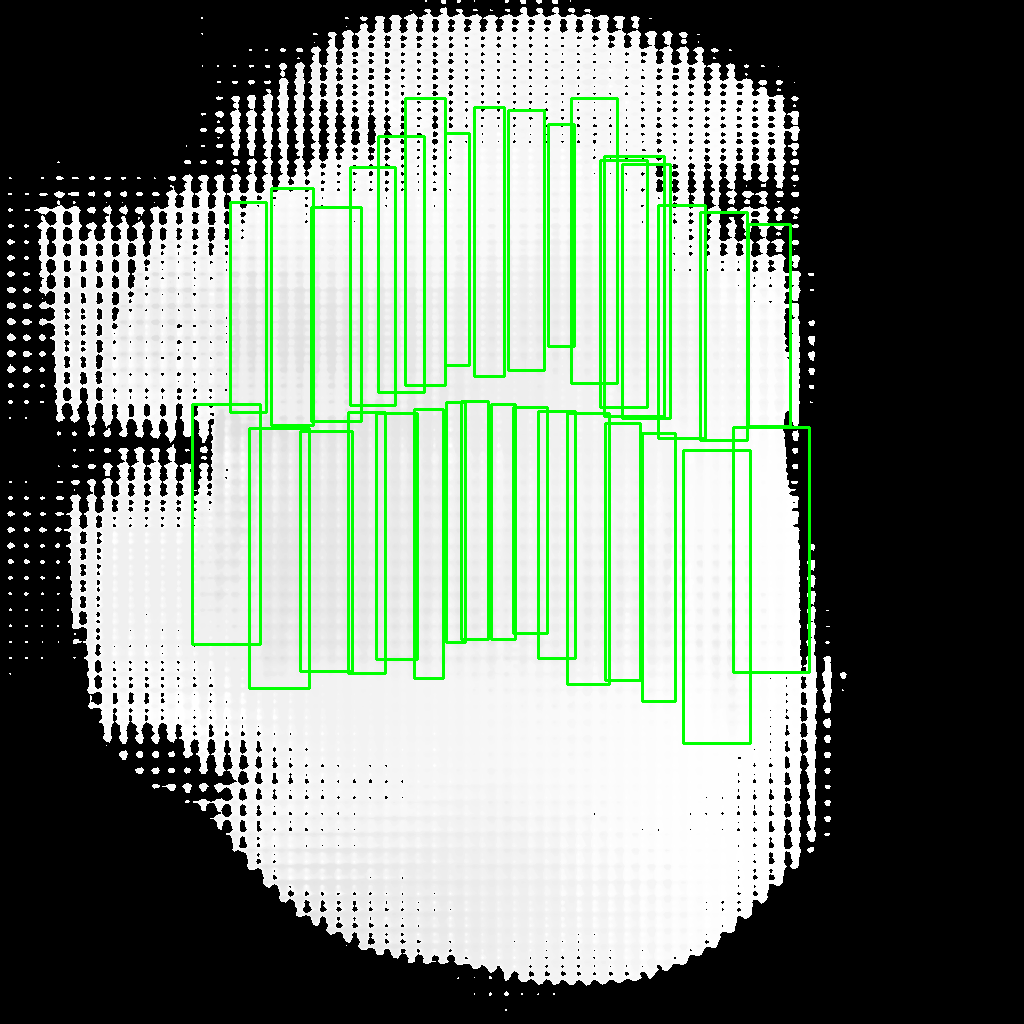

Max, min in prediction tensor(33., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 25%|██▌       | 25/100 [03:47<11:12,  8.97s/it]

Loss: 95.83497619628906

0: 288x640 33 tooths, 12.5ms
Speed: 3.0ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1024, 1024, 3)


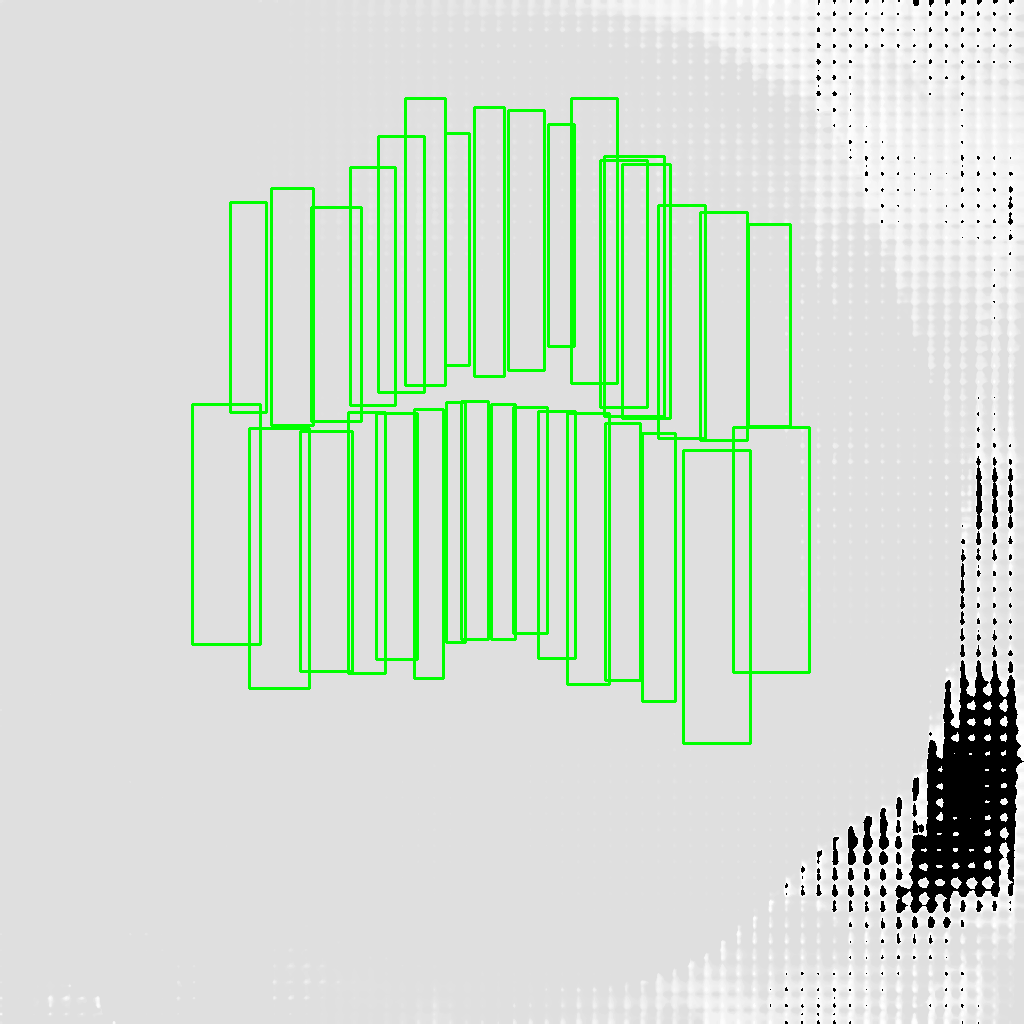

Max, min in prediction tensor(33., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 26%|██▌       | 26/100 [03:57<11:25,  9.26s/it]

Loss: 951.51416015625

0: 288x640 33 tooths, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)


 26%|██▌       | 26/100 [04:05<11:38,  9.45s/it]


KeyboardInterrupt: 

In [13]:
from ultralytics import YOLO
from torch.nn.functional import threshold, normalize
from tqdm import tqdm
import random
import gc
import torch
from segment_anything import sam_model_registry

sam_model = sam_model_registry['vit_h'](checkpoint='sam_vit_h_4b8939.pth')
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters())
loss_fn = torch.nn.MSELoss()

gc.collect()
torch.cuda.empty_cache()

yolo_model = YOLO("/content/drive/MyDrive/DentalImages/TrainingCheckpoints/best_yolov8.pt")
EPOCHS = 100
MODEL_SAVE_PATH = '/content/SAM'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam_model.to(device)
yolo_model.to(device)

#Training loop
random_select = random.randint(0,87)
for _ in tqdm(range(EPOCHS)):


  #The weird indexing is meant to add the batch dimension
  image = x_train[random_select:random_select+1].copy()
  yolo_image = x_train_yolo[random_select].copy()
  gt_mask = y_train[random_select:random_select+1].copy()

  image = image.astype(np.float32)
  image /= 255.0
  image = torch.from_numpy(image)

  image = image.to(device)


  with torch.no_grad():
    image_embedding = sam_model.image_encoder(image)
    results = yolo_model.predict(yolo_image)

    boxes = results[0].boxes.xywhn
    boxes = torch.Tensor.cpu(boxes)
    box_list = []
    for box in boxes:
      x1, y1, x2, y2 = get_fixed_coordinates(box,image[0,0,:,:])
      box_list.append([x1, y1, x2, y2])
    if len(box_list) == 0:
      continue
    box_tensor = torch.tensor(box_list)

    box_tensor = box_tensor.to(device)
    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
              points=None,
              boxes=box_tensor,
              masks=None,
          )

  low_res_masks, iou_predictions = sam_model.mask_decoder(
    image_embeddings=image_embedding,
    image_pe=sam_model.prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    multimask_output=False,
  )



  upscaled_masks = sam_model.postprocess_masks(low_res_masks, (1024,1024),(1024,1024)).to("cpu")

  binary_mask = normalize(threshold(upscaled_masks, 0.0, 0)).to("cpu")
  # print("Mask shape",gt_mask.shape,"original_shape",image.shape,"yolo_shape", yolo_image.shape)
  full_mask = torch.sum(binary_mask, axis=0)
  full_mask = full_mask[0]
  copy = full_mask.clone()
  copy = copy.detach().numpy()
  copy = copy*255
  copy = copy.astype(np.uint8)
  copy = cv2.cvtColor(copy, cv2.COLOR_GRAY2RGB)
  print("Full mask shape",copy.shape)
  for box in box_list:
    x1, y1, x2, y2 = box[:]
    cv2.rectangle(copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
  cv2_imshow(copy)

  # print("GENERATED MASK", binary_mask.shape)
  # cv2_imshow((binary_mask[0,0,:,:].detach().numpy()*255).astype(np.uint8))
  gt_mask = gt_mask.astype(np.float32)
  gt_mask /= 255.0
  gt_mask = torch.from_numpy(gt_mask)
  print("Max, min in prediction",torch.max(full_mask), torch.min(full_mask))
  print("Max, min in gt",torch.max(gt_mask), torch.min(gt_mask))
  # print("GT Mask", gt_mask.shape)
  # cv2_imshow((gt_mask[4,0,:,:].numpy()*255).astype(np.uint8))

  loss = loss_fn(full_mask, gt_mask)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  print("Loss:",loss.item())
torch.save(sam_model, MODEL_SAVE_PATH)